librerias importadas

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


Se importa el Dataset de Kaggle

In [9]:
import kagglehub

def load_data():
    print("Descargando dataset desde Kaggle...")
    path = kagglehub.dataset_download("sahilislam007/loan-factors-prediction-dataset")
    df = pd.read_csv(os.path.join(path, "synthetic_loan_data.csv"))
    df.drop(columns=["CustomerID", "Name"], inplace=True)
    return df


Preprosesamiento de Datos

In [10]:
def preprocess(df):
    for col in df.select_dtypes(include="object").columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

Exploracion de los Datos

Descargando dataset desde Kaggle...
Vista previa de los datos:


,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,AnnualIncome,LoanAmountRequested,PurposeOfLoan,CreditScore,ExistingLoansCount,LatePaymentsLastYear,LoanApproved
0,56,1,0,3,0,97622,46413,4,500,2,4,1
1,69,1,1,0,0,96925,24065,3,532,2,0,1
2,46,0,2,1,2,167927,46676,4,795,2,6,1
3,32,0,3,4,4,112920,27406,2,376,2,9,0
4,60,0,3,2,4,152183,49337,1,517,3,7,0



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   9000 non-null   int64
 1   Gender                9000 non-null   int64
 2   MaritalStatus         9000 non-null   int64
 3   EducationLevel        9000 non-null   int64
 4   EmploymentStatus      9000 non-null   int64
 5   AnnualIncome          9000 non-null   int64
 6   LoanAmountRequested   9000 non-null   int64
 7   PurposeOfLoan         9000 non-null   int64
 8   CreditScore           9000 non-null   int64
 9   ExistingLoansCount    9000 non-null   int64
 10  LatePaymentsLastYear  9000 non-null   int64
 11  LoanApproved          9000 non-null   int64
dtypes: int64(12)
memory usage: 843.9 KB

Estadísticas descriptivas:


,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,AnnualIncome,LoanAmountRequested,PurposeOfLoan,CreditScore,ExistingLoansCount,LatePaymentsLastYear,LoanApproved
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,43.550444,0.501333,1.488778,2.026333,2.013000,110279.808556,25680.583333,2.018111,573.193333,2.008444,4.475444,0.700333
std,14.909264,0.500026,1.117940,1.423017,1.398866,52147.330689,14116.494549,1.418766,158.013843,1.414110,2.878403,0.458137
min,18.000000,0.000000,0.000000,0.000000,0.000000,20009.000000,1000.000000,0.000000,300.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,0.000000,1.000000,1.000000,65443.250000,13564.750000,1.000000,437.000000,1.000000,2.000000,0.000000
50%,43.000000,1.000000,1.000000,2.000000,2.000000,110331.000000,25814.000000,2.000000,574.000000,2.000000,4.000000,1.000000
75%,56.000000,1.000000,2.000000,3.000000,3.000000,155539.250000,37941.500000,3.000000,708.000000,3.000000,7.000000,1.000000
max,69.000000,1.000000,3.000000,4.000000,4.000000,199988.000000,49989.000000,4.000000,849.000000,4.000000,9.000000,1.000000



Distribución de la variable objetivo 'LoanApproved':


,count
LoanApproved,
1,6303
0,2697


/tmp/ipython-input-11-2955079853.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LoanApproved', data=df, palette='Set2')


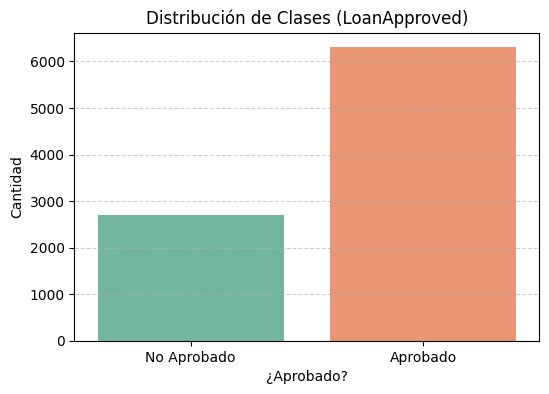

In [11]:
df = load_data()
df = preprocess(df)
print("Vista previa de los datos:")
display(df.head())

print("\nInformación del dataset:")
df.info()

print("\nEstadísticas descriptivas:")
display(df.describe())

print("\nDistribución de la variable objetivo 'LoanApproved':")
class_counts = df['LoanApproved'].value_counts()
display(class_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='LoanApproved', data=df, palette='Set2')
plt.title("Distribución de Clases (LoanApproved)")
plt.xticks(ticks=[0, 1], labels=["No Aprobado", "Aprobado"])
plt.xlabel("¿Aprobado?")
plt.ylabel("Cantidad")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Definicion del Algoritmo GWO (Grey Wolf optimizer)

In [12]:
def GWO(obj_func, dim, lb, ub, n_agents, max_iter, patience, tol=1e-6):
    positions = np.random.uniform(lb, ub, (n_agents, dim))

    alpha_pos, beta_pos, delta_pos = np.zeros(dim), np.zeros(dim), np.zeros(dim)
    alpha_score = beta_score = delta_score = float("inf")

    no_improve_count = 0
    prev_alpha_score = alpha_score
    eval_count = n_agents

    for i in range(n_agents):
        positions[i] = np.clip(positions[i], lb, ub)
        fitness = obj_func(positions[i])
        if fitness < alpha_score:
            delta_score, delta_pos = beta_score, beta_pos.copy()
            beta_score, beta_pos = alpha_score, alpha_pos.copy()
            alpha_score, alpha_pos = fitness, positions[i].copy()
        elif fitness < beta_score:
            delta_score, delta_pos = beta_score, beta_pos.copy()
            beta_score, beta_pos = fitness, positions[i].copy()
        elif fitness < delta_score:
            delta_score, delta_pos = fitness, positions[i].copy()

    header = "Iter | EvalCount |   AlphaF   |   BetaF    |   DeltaF"
    print(header)
    print("-" * len(header))

    for t in range(max_iter):
        print(f"{t:4d} | {eval_count:9d} | {alpha_score:9.5f} | {beta_score:9.5f} | {delta_score:9.5f}")
        a = 2 - t * (2 / max_iter)
        for i in range(n_agents):
            for j in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - positions[i, j])
                X1 = alpha_pos[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C2 * beta_pos[j] - positions[i, j])
                X2 = beta_pos[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C3 * delta_pos[j] - positions[i, j])
                X3 = delta_pos[j] - A3 * D_delta

                positions[i, j] = (X1 + X2 + X3) / 3

        for i in range(n_agents):
            positions[i] = np.clip(positions[i], lb, ub)
            fitness = obj_func(positions[i])
            eval_count += 1
            if fitness < alpha_score:
                delta_score, delta_pos = beta_score, beta_pos.copy()
                beta_score, beta_pos = alpha_score, alpha_pos.copy()
                alpha_score, alpha_pos = fitness, positions[i].copy()
            elif fitness < beta_score:
                delta_score, delta_pos = beta_score, beta_pos.copy()
                beta_score, beta_pos = fitness, positions[i].copy()
            elif fitness < delta_score:
                delta_score, delta_pos = fitness, positions[i].copy()

        if abs(prev_alpha_score - alpha_score) < tol:
            no_improve_count += 1
        else:
            no_improve_count = 0
            prev_alpha_score = alpha_score

        if no_improve_count >= patience:
            print(f"Terminación anticipada en iteración {t} por falta de mejora.")
            break

    return alpha_score, alpha_pos


Funcion Objetivo Para Random Forest

In [13]:
def rf_objective(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    n_estimators = max(10, min(n_estimators, 300))
    max_depth = max(1, min(max_depth, 50))
    min_samples_split = max(2, min(min_samples_split, 20))

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight='balanced',
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring="average_precision")
    return -scores.mean()


División, Escalamiento y Optimización

In [14]:
X = df.drop("LoanApproved", axis=1)
y = df["LoanApproved"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dim = 3
lb = [10, 2, 2]
ub = [300, 50, 20]

best_score, best_params = GWO(
    obj_func=rf_objective,
    dim=dim,
    lb=lb,
    ub=ub,
    n_agents=10,
    max_iter=10,
    patience=15,
    tol=1e-5
) #100 evaluaciones!!!

best_n_estimators = int(best_params[0])
best_max_depth = int(best_params[1])
best_min_samples_split = int(best_params[2])


Iter | EvalCount |   AlphaF   |   BetaF    |   DeltaF
-----------------------------------------------------
   0 |        10 |  -0.71358 |  -0.70990 |  -0.70956
   1 |        20 |  -0.71358 |  -0.71154 |  -0.71071
   2 |        30 |  -0.71358 |  -0.71339 |  -0.71324
   3 |        40 |  -0.71459 |  -0.71358 |  -0.71339
   4 |        50 |  -0.71572 |  -0.71487 |  -0.71459
   5 |        60 |  -0.71572 |  -0.71509 |  -0.71487
   6 |        70 |  -0.71572 |  -0.71509 |  -0.71487
   7 |        80 |  -0.71572 |  -0.71509 |  -0.71502
   8 |        90 |  -0.71593 |  -0.71572 |  -0.71565
   9 |       100 |  -0.71593 |  -0.71572 |  -0.71572


Entrenamiento y Evaluacion Final


=== Resultados finales ===
              precision    recall  f1-score   support

           0       0.36      0.01      0.02       809
           1       0.70      0.99      0.82      1891

    accuracy                           0.70      2700
   macro avg       0.53      0.50      0.42      2700
weighted avg       0.60      0.70      0.58      2700

ROC AUC: 0.5014155269348858


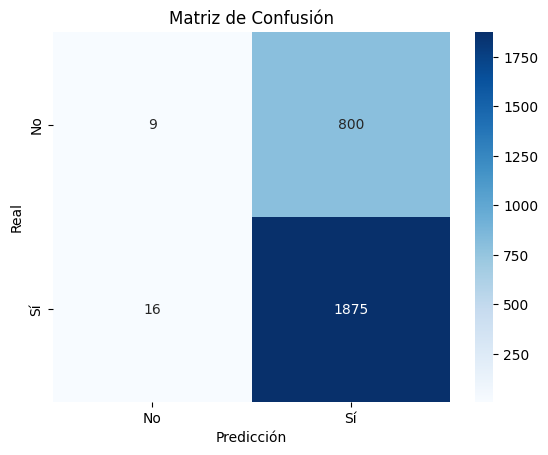

In [15]:
model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    class_weight='balanced',
    min_samples_split=best_min_samples_split,
    random_state=42
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("\n=== Resultados finales ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


--------------- SEGUNDO MODELO -------------

Entrenamiento del Modelo

In [16]:
# Entrenamiento del modelo de Regresión Logística
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]


Evaluación del Modelo


=== Resultados Regresión Logística ===
              precision    recall  f1-score   support

           0       0.31      0.51      0.38       809
           1       0.71      0.51      0.59      1891

    accuracy                           0.51      2700
   macro avg       0.51      0.51      0.49      2700
weighted avg       0.59      0.51      0.53      2700

ROC AUC: 0.5200425671272222


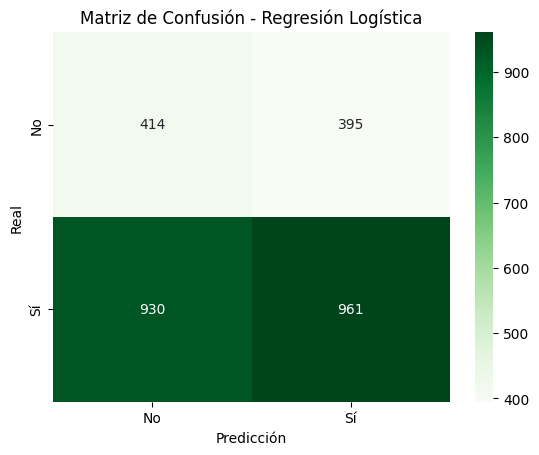

In [17]:
print("\n=== Resultados Regresión Logística ===")
print(classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))

# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


Comparacion entre Modelos

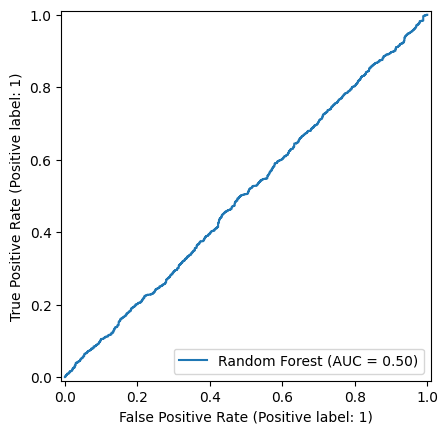

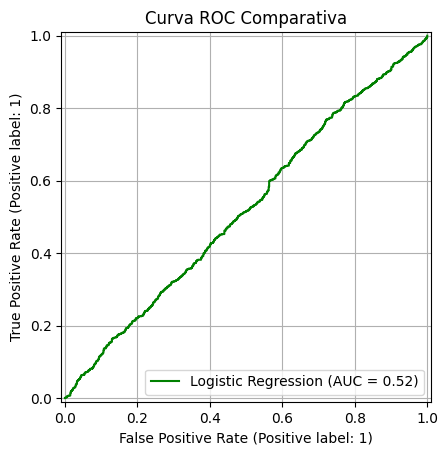

In [18]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(log_model, X_test_scaled, y_test, name="Logistic Regression", color="green")
plt.title("Curva ROC Comparativa")
plt.grid()
plt.show()


| Métrica           | Regresión Logística | Random Forest (GWO)  |
| ----------------- | ------------------- | -------------------- |
| **Accuracy**      | 0.51                | 0.70                 |
| **Precision (0)** | 0.31                | 0.36                 |
| **Recall (0)**    | 0.51                | 0.01               |
| **F1-score (0)**  | 0.38                | 0.02               |
| **Precision (1)** | 0.71                | 0.70                 |
| **Recall (1)**    | 0.51                | 0.99                |
| **F1-score (1)**  | 0.59                | 0.82                |
| **Macro Avg**     | 0.51 / 0.51 / 0.49  | 0.53 / 0.50 / 0.42   |
| **Weighted Avg**  | 0.59 / 0.51 / 0.53  | 0.60 / 0.70 / 0.58  |


Conclusión

  **Regresión Logística**

Tiene una mejor capacidad para identificar la clase 0 (no aprobado), con un recall del 51%.

Pero tiene una precisión baja en esa clase (31%), lo que indica muchos falsos positivos (casos predichos como "no aprobado" pero que sí lo estaban).

Es un modelo simple y fácil de explicar, pero no captura relaciones complejas.

  **Random Forest + GWO**

Tiene un recall del 99% para la clase 1 (aprobado), lo que significa que detecta casi todos los préstamos que fueron aprobados, ideal si se quiere minimizar falsos negativos (falsos rechazos).

Sin embargo, ignora casi completamente la clase 0, como indica su recall de 0.01 y f1-score de 0.02. Esto sugiere un fuerte desequilibrio en la predicción, probablemente causado por el sesgo hacia la clase mayoritaria o por la optimización del score average_precision.

Cual es mejor?

Depende del objetivo del negocio:

Si quieres detectar todos los préstamos aprobados, incluso a costa de equivocarte con los no aprobados → Random Forest + GWO es superior.

Si necesitas un modelo más equilibrado entre ambas clases (por ejemplo, para evitar aprobar créditos no confiables) → Regresión Logística ofrece un mejor punto de partida, aunque requiere mejora.
